这个`notebook`用一个`tensorflow`的简单例子来说明`tensorboard`的使用。使用这个notebok请先用


> conda env create -f environment_tf.yml


来创建实验环境

导入依赖包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

# 设置渲染图片的默认大小
plt.rcParams['figure.figsize'] = (10.0, 8.0)

初始化一些数据，这里使用CS231N教程中的初始化方法

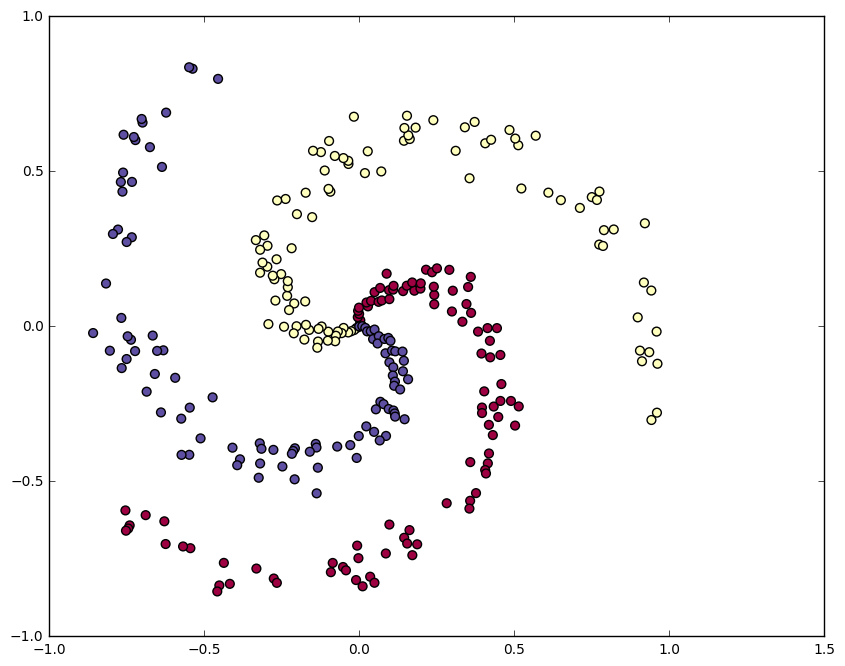

In [2]:
# 数据初始化
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N * K, D)) # data matrix (each row = single example)
y = np.zeros(N * K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N) # radius
    t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [3]:
# 创建input variable
with tf.name_scope('Inputs') as scope:
    inputs = tf.placeholder(tf.float32, [N * K, D], name='inputs')

# 创建target variable
with tf.name_scope('Targets') as scope:
    targets = tf.placeholder(tf.float32, [None, K], name='targets')

In [4]:
# 将标签数据进行one hot encode，用于计算cross entropy
y_ = tf.one_hot(y, 3, on_value=1.0, off_value=0.0)

这里要做的就是使用tensorflow做一个分类器，将上面的数据分类。

In [5]:
# hidden layer的大小
h = 100

# 创建第一层的weights和bias
with tf.name_scope('Weight_Set_1') as scope:
    softmax_w_1 = tf.Variable(tf.truncated_normal((D, h), stddev=0.1), dtype=tf.float32, name='weight_1')
    softmax_b_1 = tf.Variable(tf.zeros((1, h)), dtype=tf.float32, name='bias_1')

# 创建第二层的weights和bias
with tf.name_scope('Weight_Set_2') as scope:
    softmax_w_2 = tf.Variable(tf.truncated_normal((h, K), stddev=0.1), dtype=tf.float32, name='weight_2')
    softmax_b_2 = tf.Variable(tf.zeros((1, K)), dtype=tf.float32, name='bias_2')

计算第一层的输出

In [6]:
# 先将输入的数据转换成float32位格式，下面才能和weights做运算
X = X.astype(np.float32)

with tf.name_scope('Logits_1') as scope:
    # 第一层的输出logits_1,使用ReLU作为activation function
    logits_1 = tf.nn.relu(tf.add(tf.matmul(X, softmax_w_1), softmax_b_1), name='logits_1')

使用第一层的输出作为第二层的输入，再计算第二层的输出，第二层使用softmax计算最终的预测分数

In [7]:
with tf.name_scope('Logits_2') as scope:
    logits_2 = tf.add(tf.matmul(logits_1, softmax_w_2), softmax_b_2, name='logits_2')
    
    # 计算最终的预测分数,使用softmax计算最后的分数
    prediction = tf.nn.softmax(logits_2, name='prediction')

得到模型的预测分数之后，用cross_entropy计算和目标结果的熵

In [8]:
# 计算loss
with tf.name_scope('Loss') as scope:
    loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=prediction, name='loss'))

In [10]:
# 计算模型最终的准确率
with tf.name_scope('Accuracy') as scope:
    # Determine if the predictions are correct
    is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_, 1))
    # Calculate the accuracy of the predictions
    accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32), name='accuracy')

In [11]:
# 添加想要关注的变量
w_1_hist = tf.summary.histogram('weight_1', softmax_w_1)
b_1_hist = tf.summary.histogram('bias_1', softmax_b_1)
w_2_hist = tf.summary.histogram('weight_2', softmax_w_2)
b_2_hist = tf.summary.histogram('bias_2', softmax_b_2)
logits = tf.summary.histogram('prediction', prediction)
loss_hist = tf.summary.scalar('loss', loss)
acc_hist = tf.summary.scalar('accuracy', accuracy)

定义hyperparameter和optimizer，准备开始训练

In [12]:
# 循环次数
epochs = 15000

# 学习率
learning_rate = 0.001

with tf.name_scope('Train') as scope:
    # 使用adam最为optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

开始训练模型

In [13]:
init = tf.global_variables_initializer()

with tf.Session() as session:
    session.run(init)
    
    # 合并所有summary
    merged = tf.summary.merge_all()
    # 将summary写入到磁盘
    writer = tf.summary.FileWriter('./logs/summary', session.graph)
    
    # feeding dict
    training_feed_dict = {inputs: X, targets: y_.eval()}
    
    for i in range(epochs):
        # summary是执行merged之后返回的结果
        summary, _, l = session.run(
                [merged, optimizer, loss],
                feed_dict=training_feed_dict)

        if not i % 50:
            print('Epoch {}/{} '.format(i + 1, epochs), 
                  'Training loss: {:.4f}'.format(l))
            writer.add_summary(summary, i)
            
    validation_accuracy = session.run(accuracy, feed_dict=training_feed_dict)
    
    print('accuracy is: %.4f' % validation_accuracy)
    
    # 将tensorflow的Variable对象转换成numpay array，最后画图用到
    ww1 = np.array(softmax_w_1.eval(session))
    ww2 = np.array(softmax_w_2.eval(session))
    bb1 = np.array(softmax_b_1.eval(session))
    bb2 = np.array(softmax_b_2.eval(session))
            

Epoch 1/15000  Training loss: 1.0999
Epoch 51/15000  Training loss: 1.0467
Epoch 101/15000  Training loss: 0.9746
Epoch 151/15000  Training loss: 0.9287
Epoch 201/15000  Training loss: 0.9060
Epoch 251/15000  Training loss: 0.8878
Epoch 301/15000  Training loss: 0.8686
Epoch 351/15000  Training loss: 0.8468
Epoch 401/15000  Training loss: 0.8235
Epoch 451/15000  Training loss: 0.8008
Epoch 501/15000  Training loss: 0.7798
Epoch 551/15000  Training loss: 0.7610
Epoch 601/15000  Training loss: 0.7444
Epoch 651/15000  Training loss: 0.7299
Epoch 701/15000  Training loss: 0.7171
Epoch 751/15000  Training loss: 0.7054
Epoch 801/15000  Training loss: 0.6950
Epoch 851/15000  Training loss: 0.6854
Epoch 901/15000  Training loss: 0.6765
Epoch 951/15000  Training loss: 0.6684
Epoch 1001/15000  Training loss: 0.6611
Epoch 1051/15000  Training loss: 0.6545
Epoch 1101/15000  Training loss: 0.6486
Epoch 1151/15000  Training loss: 0.6431
Epoch 1201/15000  Training loss: 0.6382
Epoch 1251/15000  Train

(-1.8548737168312073, 1.825126283168796)

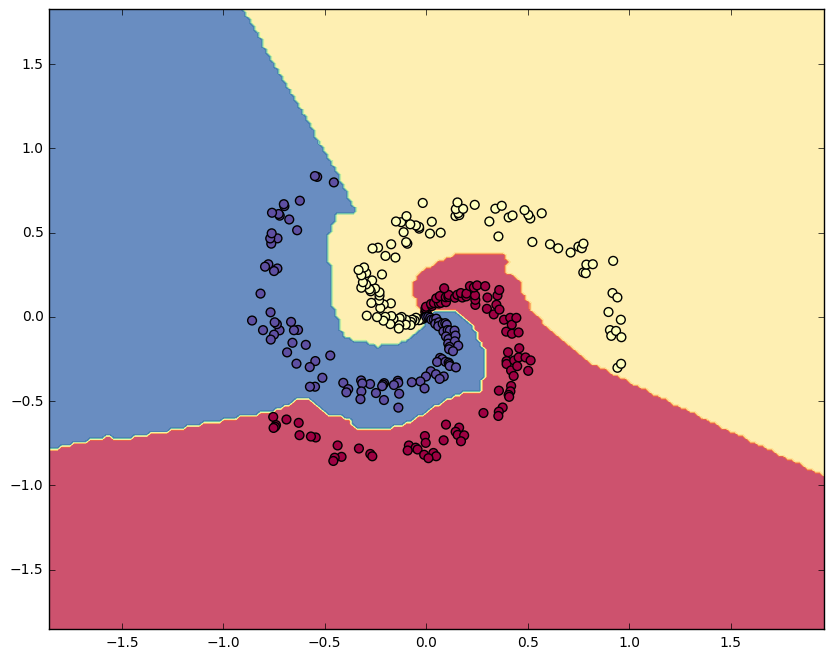

In [14]:
# 画出最后的分类结果
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], ww1) + bb1), ww2) + bb2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())